In [1]:
import datetime
import requests
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
import numpy as np

In [107]:
def get_settles_df(symbol:str, date:str) -> pd.DataFrame:
    url = f"http://settles-api.mosaic.hartreepartners.com/settles/api/v1/getFutureCurveSettlement/{symbol}/CME/{date}?allow_indicative=true"
    data = requests.get(url)
    df = pd.DataFrame(data=data.json())
    return df[['instrument_key','expiration_date','value']].reset_index(drop=True)

In [108]:
settles_t_1 = get_settles_df("RB", "2021-09-24")
settles_t_2 = get_settles_df("RB", "2021-09-23")
live = pd.read_csv('../data/RB_live_prices_20210927.csv')

In [109]:
# transform
settles_t_1.rename(columns={'value':'t-1'}, inplace=True)
settles_t_2.rename(columns={'value':'t-2'}, inplace=True)
live['live_price'] = (live['bid'] + live['ask'])/2
live.rename(columns={'instr':'instrument_key'}, inplace=True)
settles = pd.merge(settles_t_1, settles_t_2, how="inner", on=["instrument_key","expiration_date"])

In [110]:
live_futures = live[~live['instrument_key'].str.contains('-')].reset_index(drop=True).copy()
settles_futures = settles.copy()


In [111]:
df = pd.merge(settles_futures,live_futures,how="left",on='instrument_key')
df = df[['instrument_key','expiration_date','t-1','t-2','live_price']].copy()
df[['symbol','contract']] = df['instrument_key'].str.split(expand=True)

In [112]:
df = df.where(pd.notna(df),None).copy()
df.sort_values(by='instrument_key', inplace=True)

In [113]:
df['settles_price'] = df.apply(lambda row: None if row['live_price'] is None else row['t-1'], axis=1)
df['missing'] = df['live_price'].apply(lambda x:True if x is None else False)
df = df.where(pd.notna(df),None)
df = df.reset_index()

In [115]:
# df['settles_shifted'] = df['settles_price'].shift(-1, fill_value=None)
df = df.where(pd.notna(df),None)
def calc_diff(row):
    if (row['settles_price'] is None) or (row['t-2'] is None):
        row['diff'] = None
    else:
        row['diff'] = row['settles_price'] - row['t-2']
    
    return row

df = df.apply(calc_diff, axis=1)
df = df.where(pd.notna(df),None)

In [ ]:
fig = df[['contract','settles_price','t-1','t-2']].plot(x='contract').get_figure()
fig.savefig(r'c:\temp\linear_models.pdf')

In [116]:



# using scipy interpolation

df['expiration_date'] = pd.to_datetime(df['expiration_date'])
df['days_to_expiry'] = df['expiration_date'].apply(lambda x: (x - datetime.datetime.today()).days)

In [44]:
# df_sub = df[['days_to_expiry','settles_price']].dropna()
# # Interpoalte only. Extrapolation is disabled by bounds_error=False and fill_value=None 
# f=interpolate.interp1d(df_sub['days_to_expiry'],df_sub['settles_price'], 
#                        fill_value=None, bounds_error=False, kind='linear')

In [117]:
df_diffs = df[['days_to_expiry','diff']].dropna()
f_diff = interpolate.interp1d(df_diffs['days_to_expiry'], df_diffs['diff'], fill_value=None, bounds_error=False)
df = df.where(pd.notna(df),None).copy()
df['predicted_diff'] = df['days_to_expiry'].apply(f_diff)
df = df.where(pd.notna(df),None)


In [84]:
# interpolate 
# df = df.where(pd.notna(df),None).copy()
# df['price'] = df['days_to_expiry'].apply(f)
# df = df.where(pd.notna(df),None)

In [118]:
# calculate difference at last known point
ldf = df[['contract','settles_price']].dropna()
last_known_contract = ldf['contract'].max()
last_known_contract_row = df[df['contract']==last_known_contract].head(1)
print(last_known_contract_row)
last_known_diff_s = last_known_contract_row['t-2'] - last_known_contract_row['t-1']
last_known_diff = last_known_diff_s.iloc[0]

    index instrument_key expiration_date     t-1     t-2 live_price symbol  \
26     26      RB 202312      2023-11-30  1.7647  1.7608    1.79315     RB   

   contract settles_price  missing    diff  days_to_expiry predicted_diff  
26   202312        1.7647    False  0.0039             786         0.0039  


In [119]:
df = df.where(pd.notna(df),None).copy()
# extrapolate
def predict(row):
    if row['contract'] > last_known_contract:
        row['predicted'] = row['t-1'] + last_known_diff
    elif (row['contract'] <= last_known_contract) and (row['settles_price'] is None):
        row['predicted'] = row['t-2']  + row['predicted_diff']
    else:
        row['predicted'] = row['settles_price']
    
    return row
df = df.apply(predict, axis=1)

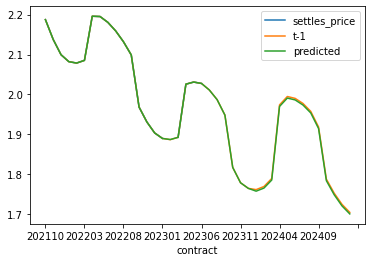

In [120]:
fig = df[['contract','settles_price','t-1','predicted']].plot(x='contract').get_figure()
fig.savefig(r'c:\temp\linear_models.pdf')

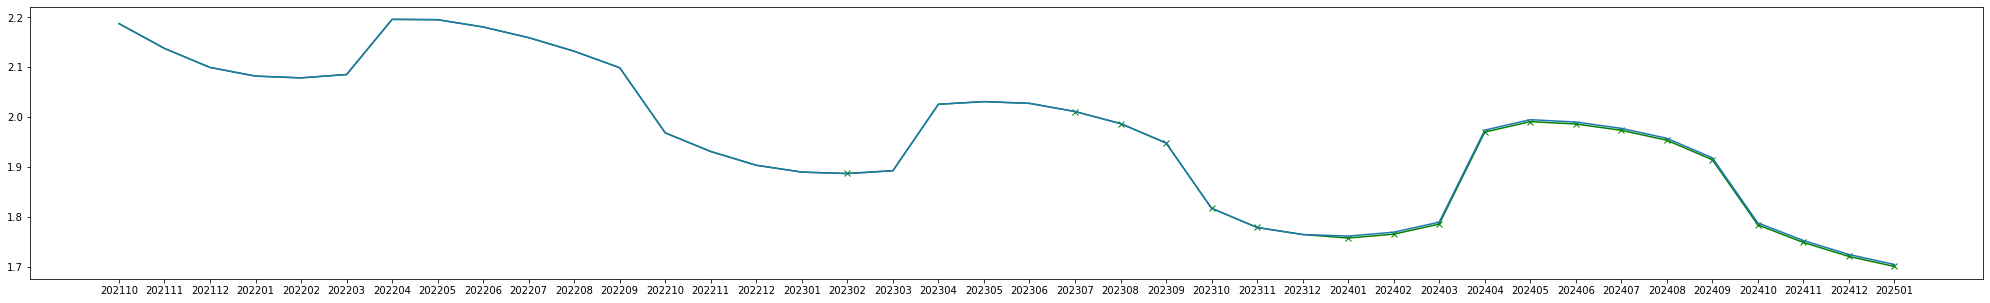

In [121]:
fig, ax = plt.subplots(figsize=(35, 5), )


ax.plot(df['contract'], df['predicted'], '-gx', markevery=list(df['missing']) , label='t-1')
ax.plot(df['contract'], df['t-1'], label='t-1')
# ax.plot(df['contract'], df['live_price'], label='live_price')
# ax.plot(df_n['contract'], df['t-2'], label='t-2')
fig.savefig(r'c:\temp\linear_models_v6.pdf')
